In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

# Metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

In [19]:
# Load the dataset
LEVEL = "small"
TRAIN_PATH = f"../data/normalize/normalized-train-ugr16-{LEVEL}.csv"
TEST_PATH = f"../data/normalize/normalized-test-ugr16-{LEVEL}.csv"

data_df = pd.read_csv(TRAIN_PATH, index_col=0)
test_df = pd.read_csv(TEST_PATH, index_col=0)

In [20]:
LABEL_COLUMN_LIST = data_df.columns[data_df.columns.str.startswith("label")]
label_serie = data_df[LABEL_COLUMN_LIST].idxmax(axis=1)

In [21]:
# Split TRAIN/VALIDATION
train_df, validation_df = train_test_split(data_df, test_size=0.1, shuffle=True, stratify=label_serie)

In [ ]:
def get_input_target(data_df):
    return data_df.drop(columns=LABEL_COLUMN_LIST), data_df[LABEL_COLUMN_LIST]

## Un seul modèle

### Train

In [88]:
x, y = get_input_target(train_df)

In [97]:
model = DecisionTreeClassifier(max_depth = 25)
model.fit(x, y)

DecisionTreeClassifier(max_depth=25)

### Test

In [98]:
def compute_score(y_true, y_pred):
    score_dict = dict()
    score_dict["accuracy_score"] = accuracy_score(y_true, y_pred)
    score_dict["f1_score"] = f1_score(y_true, y_pred, average="micro")
    score_dict["roc_auc_score"] = roc_auc_score(y_true, y_pred)
    score_dict["precision_score"] = precision_score(y_true, y_pred, average="micro")
    score_dict["recall_score"] = recall_score(y_true, y_pred, average="micro")
    return score_dict

In [99]:
x_test, y_test_true = get_input_target(test_df)

In [100]:
y_pred = model.predict(x_test)

In [101]:
compute_score(y_pred, y_test_true)

{'accuracy_score': 0.9917361111111112,
 'f1_score': 0.9917361111111112,
 'roc_auc_score': 0.9946106499718722,
 'precision_score': 0.9917361111111112,
 'recall_score': 0.9917361111111112}

#### Matrice de confusion

In [102]:
cf_matrix = confusion_matrix(y_pred.argmax(axis=1), y_test_true.values.argmax(axis=1))

In [103]:
cf_matrix_df = pd.DataFrame(cf_matrix, 
        index=LABEL_COLUMN_LIST, 
        columns=LABEL_COLUMN_LIST)
norm_cf_matrix_df = cf_matrix_df/cf_matrix_df.sum(axis=0)

Text(0.5, 1.0, "Matrice de confusion (en proportion d'exemples)")

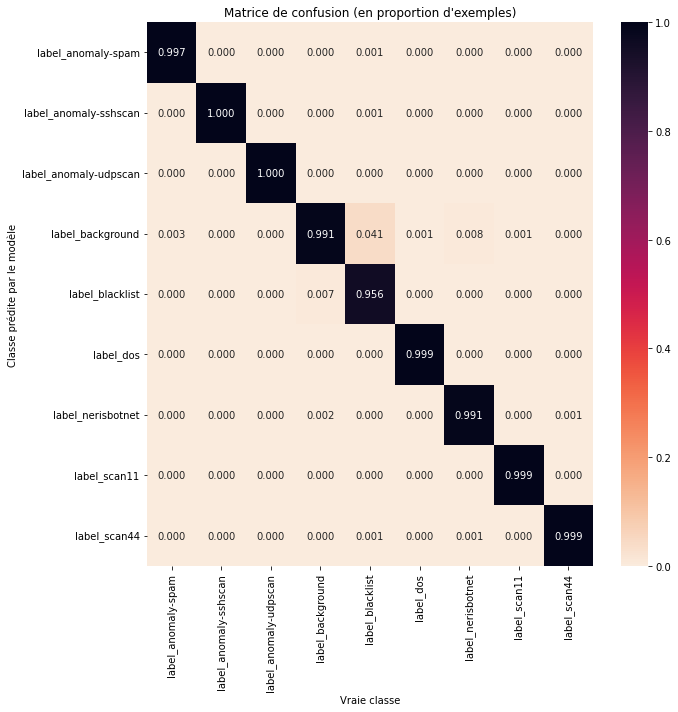

In [104]:
plt.figure(figsize=(10,10))
g = sns.heatmap(norm_cf_matrix_df,
            annot=True,
            fmt='.3f',
            cmap='rocket_r')
g.set_xlabel("Vraie classe")
g.set_ylabel("Classe prédite par le modèle")
g.set_title("Matrice de confusion (en proportion d'exemples)")